In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy[cuda102]
!pip install pandas
!pip install seaborn
!pip install sklearn
!python -m spacy download en_core_web_sm

distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages
distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages
distutils: /usr/local/include/python3.6/UNKNOWN
sysconfig: /usr/include/python3.6m
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages
distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages
distutils: /usr/local/include/python3.6/UNKNOWN
sysconfig: /usr/include/python3.6m
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages
distutils: /usr/local/lib/python3.6/dist-packages
sysconfig: /usr/lib/python3.6/site-packages


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import spacy
import requests
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split

In [ ]:
r = requests.get('http://nlp.stanford.edu/data/glove.6B.zip')

In [ ]:
open('glove.zip', 'wb').write(r.content) 

862182613

In [ ]:
!unzip glove.zip

Archive:  glove.6.B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
embeddings_dict = {}
with open("glove.6B.300d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:
len(embeddings_dict)

400000

In [ ]:
reviews_df1 = pd.read_csv('reviews.csv')
reviews_df2 = pd.read_csv('items_0_31.csv')
reviews_df3 = pd.read_csv('items_33_65.csv')
reviews_df4 = pd.read_csv('items_66_101.csv')

In [ ]:
reviews_df2 = reviews_df2.drop('Unnamed: 0', axis=1)
reviews_df2.columns = ['rating', 'text']

In [ ]:
reviews_df = pd.concat([reviews_df1, reviews_df2, reviews_df3, reviews_df4], axis=0)
reviews_df.reset_index(inplace=True)
reviews_df.drop('index', axis=1, inplace=True)

In [ ]:
reviews_df

,rating,text
0,5,\n I tested the AA size Amazon brand battery ...
1,1,\n I've been buying AA and AAA batteries from...
2,1,\n Don't buy these. I did save a bunch of $'...
3,1,\n I loved these batteries when I first star...
4,1,\n I read a lot of reviews and convinced myse...
...,...,...
43308,4,"\n I had no issues plugging in, installing th..."
43309,5,\n This is a snappy little wheel in a great f...
43310,5,"\n Had this set for a few months now, and no ..."
43311,5,\n Actually surpassed my expectations. I open...


<AxesSubplot:xlabel='rating', ylabel='count'>

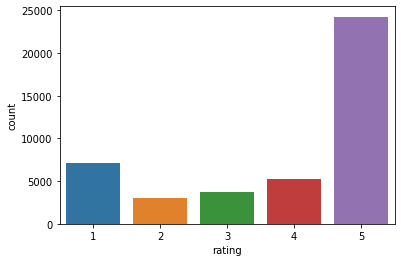

In [ ]:
sns.countplot(x='rating', data=reviews_df)

In [ ]:
reviews_df['rating'].value_counts()[5] - reviews_df['rating'].value_counts()[1]

17122

In [ ]:
#rows_to_drop = np.random.choice(reviews_df[reviews_df['rating'] == 5].index, 17000, False)
rows_to_drop1 = np.random.choice(reviews_df[reviews_df['rating'] == 5].index, 20000, False)
rows_to_drop2 = np.random.choice(reviews_df[reviews_df['rating'] == 1].index, 3000, False)
rows_to_drop3 = np.random.choice(reviews_df[reviews_df['rating'] == 4].index, 1500, False)
rows_to_drop = np.concatenate([rows_to_drop1, rows_to_drop2, rows_to_drop3])
reviews_df.drop(rows_to_drop, axis=0, inplace=True)

<AxesSubplot:xlabel='rating', ylabel='count'>

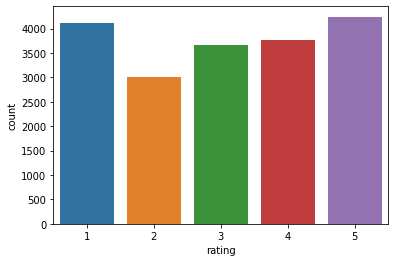

In [ ]:
sns.countplot(x='rating', data=reviews_df)

In [ ]:
MAX_SEQ_LEN = reviews_df.text.apply(lambda x: len(x.split(" "))).max()

In [ ]:
text = reviews_df.text.values
label = reviews_df.rating.values

In [ ]:
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index

In [ ]:
len(word_index)

27807

In [ ]:
seqs = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)
seqs

array([[    0,     0,     0, ...,   112,   165,   849],
       [    0,     0,     0, ...,   112,    23,   625],
       [    0,     0,     0, ...,  2280,    45,  1019],
       ...,
       [    0,     0,     0, ...,    96,   497,  2409],
       [    0,     0,     0, ...,  4243,  1345,   418],
       [    0,     0,     0, ...,     1, 27807,   620]], dtype=int32)

In [ ]:
target = tf.keras.utils.to_categorical(label)
target = target[:, 1:]
target.shape

(18813, 5)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(seqs, target, test_size=0.25, stratify=target)

In [ ]:
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

In [ ]:
for word, index in word_index.items():
    vector = embeddings_dict.get(word)
    
    if vector is not None:
        embedding_matrix[index] = vector

In [ ]:
model = Sequential()

model.add(Embedding(
    len(word_index)+1,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQ_LEN,
    trainable=False)
)
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.25, recurrent_regularizer=tf.keras.regularizers.L2(0.05))))
model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.1, recurrent_regularizer=tf.keras.regularizers.L2(0.05))))

#model.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.4, recurrent_regularizer=tf.keras.regularizers.L2(0.3))))

#model.add(TimeDistributed(Dense(32)))
#model.add(Dropout(0.2))
model.add(GlobalMaxPool1D())
model.add(Dense(128, kernel_regularizer=tf.keras.regularizers.L2(0.1)))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1573, 300)         8342400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1573, 128)         186880    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1573, 32)          18560     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
h = model.fit(train_X, train_y, batch_size=64, epochs=35, validation_data=(test_X, test_y))

Epoch 1/35
221/221 [==============================] - 61s 254ms/step - loss: 7.7203 - accuracy: 0.2895 - val_loss: 1.6003 - val_accuracy: 0.4209
Epoch 2/35
221/221 [==============================] - 55s 248ms/step - loss: 1.4898 - accuracy: 0.4249 - val_loss: 1.3273 - val_accuracy: 0.4602
Epoch 3/35
221/221 [==============================] - 55s 248ms/step - loss: 1.3178 - accuracy: 0.4558 - val_loss: 1.2630 - val_accuracy: 0.4943
Epoch 4/35
221/221 [==============================] - 55s 249ms/step - loss: 1.2331 - accuracy: 0.5066 - val_loss: 1.2366 - val_accuracy: 0.5064
Epoch 5/35
221/221 [==============================] - 55s 249ms/step - loss: 1.1990 - accuracy: 0.5195 - val_loss: 1.2089 - val_accuracy: 0.5094
Epoch 6/35
221/221 [==============================] - 55s 249ms/step - loss: 1.1563 - accuracy: 0.5373 - val_loss: 1.1881 - val_accuracy: 0.5253
Epoch 7/35
221/221 [==============================] - 55s 250ms/step - loss: 1.1178 - accuracy: 0.5456 - val_loss: 1.1917 - val_ac

In [ ]:
model.evaluate(test_X, test_y)

147/147 [==============================] - 8s 46ms/step - loss: 1.2177 - accuracy: 0.6239


[1.2176967859268188, 0.6239370703697205]

In [ ]:
preds = model.predict(test_X)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
np.apply_along_axis(lambda x: x/x.sum(), 1, confusion_matrix(np.argmax(test_y, axis=1), np.argmax(preds, axis=1)))

array([[0.65797392, 0.19458375, 0.10431294, 0.01705115, 0.02607823],
       [0.16835443, 0.47721519, 0.22531646, 0.08101266, 0.04810127],
       [0.08187773, 0.09825328, 0.62117904, 0.15283843, 0.04585153],
       [0.02111932, 0.03484688, 0.18268215, 0.62829989, 0.13305174],
       [0.04174573, 0.0227704 , 0.05787476, 0.24857685, 0.62903226]])

Text(0.5, 1.0, 'Accuracy')

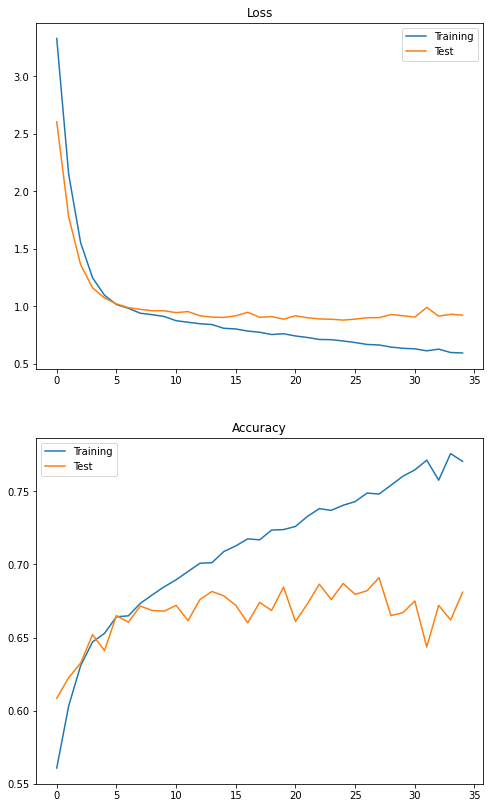

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8))

ax[0].plot(h.history['loss'], label='Training')
ax[0].plot(h.history['val_loss'], label='Test')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(h.history['accuracy'], label='Training')
ax[1].plot(h.history['val_accuracy'], label='Test')
ax[1].legend()
ax[1].set_title('Accuracy')